In [13]:
import random
from helpers import *
# random.seed(6)
# np.random.seed(6)
i=0
df = pd.read_csv('/home/guonaixin/trylab/factor-ident/simu_matrix/20Xfull'+str(i+1)+'.csv')
df =df.drop('Unnamed: 0',axis=1)
Z = np.array(df,dtype = 'float64')

# redefine Z to be all the other columns except the last one
n,p= Z.shape
Znorm = normalize_columns(Z)
mu0 = np.mean(Znorm, axis=0)
Sigma0 = np.cov(Znorm.T)
#Gamma0 = np.zeros((p, p))
Gamma0 =np.random.normal(0.0001,0.001,(p,p))
#find best sr
# St = sr_best(Znorm,lambda_val = 0.01, sigma = 500, T = 10000)
# print(St)
St=np.array([ 0, 4, 6, 9, 22])
Z0 = Z[:,St]
Gamma0[St] = np.linalg.inv(Z0.T@Z0)@Z0.T@Z

Gamma = cp.Variable((p,p))
Gamma.value = Gamma0
############ Sigma 1 ###################
Sigma = np.cov((Z-Z@Gamma.value).T)
############ Sigma 2 ###################
# Sigma = (Z-Z@Gamma0).T@(Z-Z@Gamma0)/n
############ Sigma 3 ###################
# k=5
# U, S, V =  np.linalg.svd(Z)
# Z_approx = U[:, :k] @ np.diag(S[:k]) @ V[:k, :]
# # Calculate the difference between the rank-k approximation and the actual values
# difference = Z - Z_approx
# Sigma = np.cov(np.transpose(difference), rowvar=True)  
# Sigma_inverse = np.linalg.inv(covariance_matrix) / 10**17

S,U=np.linalg.eig(Sigma)
Sigma_half_inv =U@np.diag(np.sqrt(1/S))@U.T/ 10**13

for i in range(1):
    objective = cp.Minimize(cp.norm( Sigma_half_inv @ Z.T - Sigma_half_inv @ Gamma.T @ Z.T  , 'fro')**2)
    # Define the constraint
    constraints = [
        cp.sum(cp.norm(Gamma, 2, axis=1))<=5
    ]
    # Define the optimization problem
    problem = cp.Problem(objective, constraints)
    # Solve the optimization problem
    result = problem.solve()

St0= chosen_set_with_press(Gamma.value,5,Znorm)[0]
print(np.linalg.norm(Gamma.value, axis=1))
print(St0,'sr',sr(np.linalg.solve(Sigma0[St0][:, St0], mu0[St0]), mu0[St0], Sigma0[St0][:, St0]) )


[8.74469887e-05 1.45996978e-05 2.33585915e-05 1.56420666e-05
 4.01194894e-05 5.61678507e-05 1.66474207e-05 7.15353929e-08
 1.61434127e-05 1.27314027e-04 8.16909296e-06 2.34963023e-05
 1.70911911e-05 1.32638001e-05 6.09953854e-06 1.55389300e-05
 2.05690640e-06 1.44902626e-05 7.71637947e-06 1.55911962e-05
 5.36333600e-06 1.10601985e-05 6.74591805e-05 1.06074225e-05
 5.29169198e-06]
[9, 0, 22, 5, 4] sr 0.10560294716641169


In [3]:

import numpy as np

import pandas as pd
import warnings

from helpers import *

warnings.filterwarnings('ignore')
fama285_ = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/Fama285_22.csv')
fama285 = fama285_[fama285_.columns[1:]]
df99 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X99_22.csv')
dff99 = df99[df99.columns[1:]]
df22 = pd.read_csv('/home/guonaixin/trylab/factor-ident/empirical_data/X22_22.csv')
dff22 = df22[df22.columns[1:]]
df99['Unnamed: 0'] = fama285_['Date']
df22['Unnamed: 0'] = fama285_['Date']

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
opt Index(['ACI', 'CLA', 'dROE1', 'EPRD', 'ME', 'CMA', 'HMLM', 'REG', 'IVOL',
       'BETA', 'PEAD'],
      dtype='object')
sr 0.5289841169962852


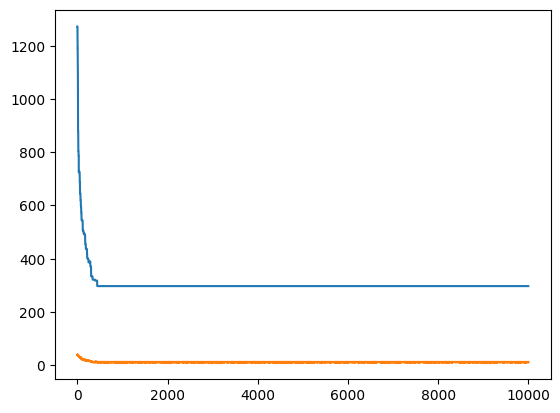

In [2]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =10000
sigma =100
lambd =20
k = 9#or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)


Sigma_inv = np.linalg.inv(Sigma)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(
        -sigma * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd * len(S_new)
        +sigma * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd * len(St)
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * Theta[0] @ Sigma_inv @Theta[0].T + lambd * len(St)
    if SRwPenalty[t]<0:
        print(SRwPenalty[t], Theta[0] @ Sigma_inv @Theta[0].T )
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

initial Index(['STR', 'REG', 'HMLM', 'PEAD', 'IVOL', 'QMJ', 'EPRD', 'IMD', 'Abr1',
       'DP', 'CLA', 'dROE1', 'MKTRF', 'IA', 'BAB', 'IAq1', 'SMB', 'CMA', 'OPA',
       'ISq1', 'dPIA', 'LIQ', 'NI', 'dFIN', 'COP', 'ILR1', 'CIM1', 'dLTI',
       'SIM1', 'FIN', 'ILE1', 'ISFF1', 'ME', 'HS', 'RER', 'OP', 'ETR', 'r1a',
       'IR', 'ETL'],
      dtype='object')
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 59, 65, 66, 72, 77, 78, 81, 83, 84, 85, 86, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 65, 66, 72, 77, 78, 81, 83, 84, 85, 86, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 24, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 65, 66, 72, 77, 81, 83, 84, 85, 86, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 30, 31, 32, 34, 35, 37, 38, 41, 42, 43, 47, 58, 65, 66, 72, 77, 81, 83, 84, 85, 86, 89, 90, 92, 94, 95, 97, 98}
{0, 5, 6, 7, 13, 17, 21, 22, 30, 31, 32, 34, 35, 37, 

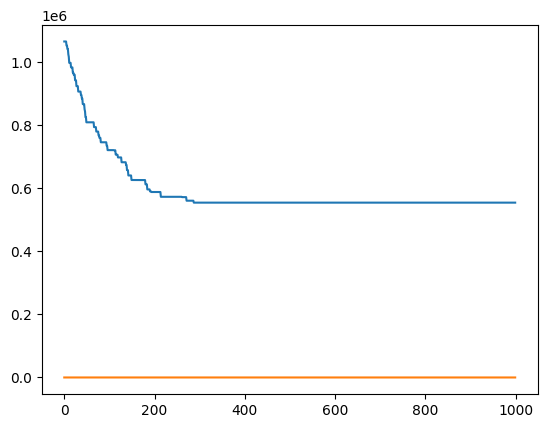

In [16]:
from helpers import  *
Z = dff99.values
Z = normalize_columns(Z)
T =1000
sigma =1
lambd1 =20
lambd2 =20000
k = 9#or 9

n, p = Z.shape
Mh = compute_k_truncated_svd(Z, k)[0]  # Perform k-truncated SVD of Z

# Calculate sample mean and sample covariance matrix

# n, p = Z.shape
# U = np.zeros((n, k))
alpha_hat = np.zeros(p)
e1 = np.eye(p+1)[0]
Z_hat = np.zeros_like(Z)
for i in range(p):
    Z_minus_i = np.delete(Z, i, axis=1)
    Ui,Si,Vi = np.linalg.svd(Z_minus_i)
    X = np.hstack((np.ones((n, 1)), Ui[:,:k]))
    beta = np.linalg.lstsq(X, Z[:, i], rcond=None)[0]
    alpha_hat[i]=beta[0]
    Z_hat[:, i] = np.dot(X, beta)
Sigma = np.cov(Z - Z_hat, rowvar=False)   


# alpha_hat = np.abs(np.mean(Z - Mh, axis=0))
# Sigma = np.cov((Z - Mh).T)
S,U=np.linalg.eig(Sigma)
S = np.abs(S)
Sigma_inv = np.linalg.inv(Sigma)
Sigma_half_inv =np.linalg.inv(U@np.diag(np.sqrt(S))@U.T)
# Initialize S1 with indices of top 2k largest values of alpha_i / sqrt(Sigma_ii)
indices = np.argsort(alpha_hat / np.sqrt(np.diag(Sigma)))[::-1][:40]
print('initial', dff99.columns[indices])

St = set(indices)
Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
SRwPenalty = np.zeros(T)
#record the subset selection in each MH update
Sseq = np.zeros((p, T))


for t in range(T):
    j = np.random.randint(p)  # Generate a random index
    # Create new subset S_new by adding or removing j
    
    if j in St:
        S_new = St - {j}
    else:
        S_new = St | {j}
        
    Z_S_new = np.concatenate((np.ones((n,1)),Z[:, list(S_new)]),axis=1)    
    Theta_new = np.linalg.inv(Z_S_new.T @ Z_S_new+lambd1*e1@e1.T) @ Z_S_new.T  @ Z 

    # Calculate the new Theta and acceptance probability
   
    # acceptance_prob = np.exp(
    #     -sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
    #     - lambd * len(S_new)
    #     +sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
    #     + lambd * len(St)
    # )
    acceptance_prob = np.exp(-sigma * np.linalg.norm(( Sigma_half_inv @ Z.T) - ( Sigma_half_inv  @ (Z_S_new @ Theta_new).T), 'fro')**2
        -lambd1 * Theta_new[0]@ Sigma_inv @Theta_new[0].T
        -lambd2 * len(S_new)
        +sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2
        +lambd1 * Theta[0]@ Sigma_inv @Theta[0].T
        + lambd2 * len(St)
        
    )
    
    # Set the new subset S_t+1 with probability according to acceptance probability
    if np.random.rand() < acceptance_prob:
        St = S_new
        print(St)
        Z_St = np.concatenate((np.ones((n,1)),Z[:, list(St)]),axis=1)
        Theta = np.linalg.inv(Z_St.T @ Z_St+lambd1*e1@e1.T) @ Z_St.T  @ Z 
    Sseq[list(S_new), t] = 1
    #record Sharpe ratio + penalty
    SRwPenalty[t] =  sigma * np.linalg.norm((Sigma_half_inv @ Z.T) - ( Sigma_half_inv @ (Z_St@ Theta).T), 'fro')**2+lambd1 * Theta[0]@ Sigma_inv @Theta[0].T + lambd2 * len(St)
   
import matplotlib.pyplot as plt
#Plots
plt.plot(SRwPenalty)
plt.plot(np.sum(Sseq, axis=0))    
sridx = np.argmin(SRwPenalty)
#Find the indices of selected factors
Sopt = np.where(Sseq[:, sridx])[0]
print('opt',dff99.columns[Sopt])

mu = np.mean(Z, axis=0)
Sigma = np.cov(Z.T)
wt = np.linalg.solve(Sigma[Sopt][:, Sopt], mu[Sopt])
print('sr',sr(wt, mu[Sopt], Sigma[Sopt][:, Sopt]))

    

In [10]:
Theta

array([[ 0.00191912,  0.00191912,  0.00191912, ...,  0.00191912,
         0.00191912,  0.00191912],
       [ 0.97533854, -0.02466146, -0.02466146, ..., -0.02466146,
        -0.02466146, -0.02466146],
       [-0.01358104,  0.98641896, -0.01358104, ..., -0.01358104,
        -0.01358104, -0.01358104],
       ...,
       [-0.05717931, -0.05717931, -0.05717931, ...,  0.94282069,
        -0.05717931, -0.05717931],
       [ 0.01726096,  0.01726096,  0.01726096, ...,  0.01726096,
         1.01726096,  0.01726096],
       [ 0.04148867,  0.04148867,  0.04148867, ...,  0.04148867,
         0.04148867,  1.04148867]])